In [1]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

In [15]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, input_dims, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [23]:
class PolicyGradientAgent():
    def __init__(self, lr, input_dims, gamma=0.99, n_actions=4):
        self.gamma = gamma
        self.lr = lr
        self.reward_memory = []
        self.action_memory = []

        self.policy = PolicyNetwork(self.lr, input_dims, n_actions)

    def choose_action(self, observation):
#         state = T.Tensor([observation]).to(self.policy.device)
        state = T.Tensor(np.array([observation])).to(self.policy.device)
        probabilities = F.softmax(self.policy.forward(state))
        # https://pytorch.org/docs/stable/distributions.html
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        return action.item()

    def store_rewards(self, reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()

        # G_t = R_t+1 + gamma * R_t+2 + gamma**2 * R_t+3
        # G_t = sum from k=0 to k=T {gamma**k * R_t+k+1}
        G = np.zeros_like(self.reward_memory, dtype=np.float64)
        for t in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1
            for k in range(t, len(self.reward_memory)):
                G_sum += self.reward_memory[k] * discount
                discount *= self.gamma
            G[t] = G_sum
        G = T.tensor(G, dtype=T.float).to(self.policy.device)
        
        loss = 0
        for g, logprob in zip(G, self.action_memory):
            # -g bec. it's gradient ascent
            # https://pytorch.org/docs/stable/distributions.html
            loss += -g * logprob
        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []


In [24]:
def plot_learning_curve(scores, x, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
#     plt.savefig(figure_file) 

/var/folders/jd/cghnyyt95l311hw30yl_42d80000gp/T/ipykernel_42366/346005588.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.policy.forward(state))


episode  0 score 38.01 average score 38.01
episode  100 score -196.89 average score -194.58
episode  200 score -125.26 average score -186.71
episode  300 score -93.01 average score -168.36
episode  400 score -137.02 average score -152.83
episode  500 score -77.61 average score -148.35
episode  600 score -36.66 average score -128.33
episode  700 score -87.85 average score -120.82
episode  800 score -93.48 average score -129.52
episode  900 score 24.67 average score -125.02
episode  1000 score -200.55 average score -116.09
episode  1100 score -47.40 average score -102.08
episode  1200 score 4.71 average score -63.20
episode  1300 score -16.71 average score -65.04
episode  1400 score -57.65 average score -56.31
episode  1500 score 29.64 average score -47.17
episode  1600 score -18.68 average score -47.13
episode  1700 score 14.01 average score -36.17
episode  1800 score 57.22 average score -27.94
episode  1900 score -41.12 average score 6.61
episode  2000 score 5.16 average score 31.66
ep

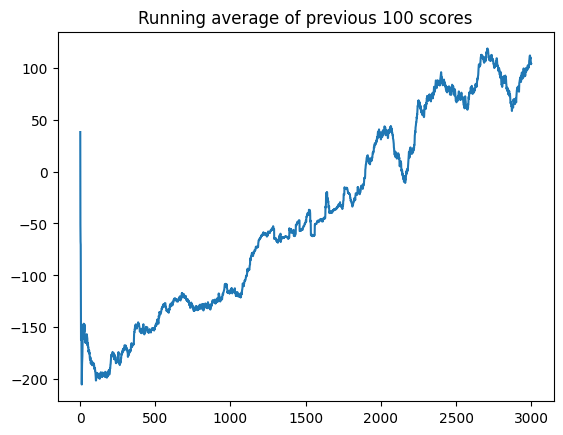

In [25]:
env = gym.make('LunarLander-v2')
n_games = 3000
agent = PolicyGradientAgent(gamma=0.99, lr=0.0005, input_dims=[8],
                            n_actions=4)

fname = 'REINFORCE_' + 'lunar_lunar_lr' + str(agent.lr) + '_' \
        + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

scores = []
for i in range(n_games):
    done = False
    observation = env.reset()[0]
    score = 0
    iter = 0
    while not done and iter < 10000:
        action = agent.choose_action(observation)
        observation_, reward, done, trunc, info = env.step(action)
        score += reward
        agent.store_rewards(reward)
        observation = observation_
        iter += 1
    # notice that learn is at the end of each episode
    agent.learn()
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    if i % 100 == 0:
        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score)

x = [i+1 for i in range(len(scores))]
plot_learning_curve(scores, x, figure_file)

/var/folders/jd/cghnyyt95l311hw30yl_42d80000gp/T/ipykernel_42366/346005588.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.policy.forward(state))


episode  0 score 21.00 average score 21.00
episode  100 score 57.00 average score 30.52
episode  200 score 81.00 average score 79.97
episode  300 score 259.00 average score 165.47
episode  400 score 406.00 average score 190.36
episode  500 score 169.00 average score 240.22
episode  600 score 1799.00 average score 464.67
episode  700 score 579.00 average score 374.27
episode  800 score 407.00 average score 1013.52
episode  900 score 435.00 average score 322.81


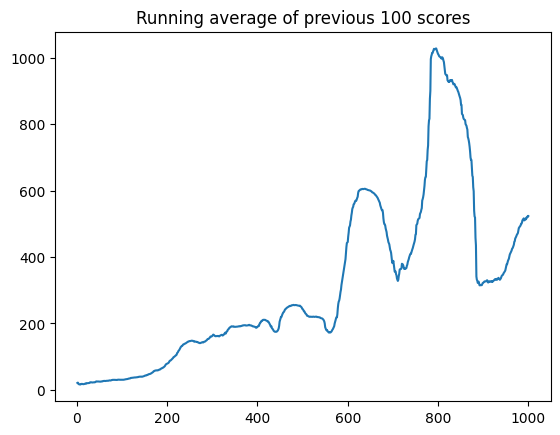

In [28]:
env = gym.make('CartPole-v1')
# num_features
D = env.observation_space.shape[0]

# num actions, num targets for policy prediction
K = env.action_space.n
n_games = 1000
agent = PolicyGradientAgent(gamma=0.99, lr=0.0005, input_dims=[D],
                            n_actions=K)

fname = 'REINFORCE_' + 'lunar_lunar_lr' + str(agent.lr) + '_' \
        + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

scores = []
for i in range(n_games):
    done = False
    observation = env.reset()[0]
    score = 0
    iter = 0
    while not done and iter < 10000:
        action = agent.choose_action(observation)
        observation_, reward, done, trunc, info = env.step(action)
        score += reward
        agent.store_rewards(reward)
        observation = observation_
        iter += 1
    # notice that learn is at the end of each episode
    agent.learn()
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    if i % 100 == 0:
        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score)

x = [i+1 for i in range(len(scores))]
plot_learning_curve(scores, x, figure_file)